Name: Paris Wang

# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, levene
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

## Load the data

In [2]:
url = "https://raw.githubusercontent.com/pariscwang/dementia-mri-analysis/main/dementia-mri-data.csv"
df = pd.read_csv(url)

In [3]:
# Double check data frame
df.head(5)

,Unnamed: 0,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  294 non-null    int64  
 1   Subject ID  294 non-null    object 
 2   MRI ID      294 non-null    object 
 3   Group       294 non-null    object 
 4   Visit       294 non-null    int64  
 5   MR Delay    294 non-null    int64  
 6   M/F         294 non-null    object 
 7   Hand        294 non-null    object 
 8   Age         294 non-null    int64  
 9   EDUC        294 non-null    int64  
 10  SES         279 non-null    float64
 11  MMSE        293 non-null    float64
 12  CDR         294 non-null    float64
 13  eTIV        294 non-null    int64  
 14  nWBV        294 non-null    float64
 15  ASF         294 non-null    float64
dtypes: float64(5), int64(6), object(5)
memory usage: 36.9+ KB


In [5]:
# Drop the first two column
df=df.drop(df.columns[0],axis=1)
df=df.drop(df.columns[1],axis=1)

In [6]:
df.head(5)

,Subject ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0004,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444


# Initial Feature Engineering

## Feature Meaning

Magnetic resonance (MR) delay is the delay time that is prior to the image procurement


Hand: dominant hand


EDUC is the subject's education level in years


SES: Socioeconomic Status


MMSE: Mini-mental state examination score


CDR: Clinical Dementia Rating


eTIV: Estimated Total Intracranial Volume


nWBV: Normalize Whole Brain Volume (the ratio of an individual's brain volume to the cranial volume, adjusted for or normalized to account for variations in head size among different individuals, indicator of brian size)


ASF: Atlas scaling factor


Adjusted Brain Volume = Individual's Raw Brain Volume x ASF

NWBV= Adjusted Brain Volume / eTIV




In [7]:
df['Group'].value_counts()

Group
Nondemented    142
Demented       126
Converted       26
Name: count, dtype: int64

In [8]:
# Rename columns
df.rename(columns={'EDUC':'Edu'}, inplace = True)
df.rename(columns={'M/F':'Gender'}, inplace = True)

In [9]:
df.head(5)

,Subject ID,Group,Visit,MR Delay,Gender,Hand,Age,Edu,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0004,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444


Reseach Question: correlation between demographic characteristics and dimentia?
- Gender
- Age
- edu
- socioeconomic status

# Data Cleaning & EDA

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  294 non-null    object 
 1   Group       294 non-null    object 
 2   Visit       294 non-null    int64  
 3   MR Delay    294 non-null    int64  
 4   Gender      294 non-null    object 
 5   Hand        294 non-null    object 
 6   Age         294 non-null    int64  
 7   Edu         294 non-null    int64  
 8   SES         279 non-null    float64
 9   MMSE        293 non-null    float64
 10  CDR         294 non-null    float64
 11  eTIV        294 non-null    int64  
 12  nWBV        294 non-null    float64
 13  ASF         294 non-null    float64
dtypes: float64(5), int64(5), object(4)
memory usage: 32.3+ KB


In [11]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Visit,294.0,1.49,0.50,1.00,1.00,1.00,2.00,2.00
MR Delay,294.0,349.79,400.74,0.00,0.00,0.00,671.50,1707.00
Age,294.0,76.41,7.61,60.00,71.00,76.00,81.00,98.00
Edu,294.0,14.56,2.88,6.00,12.00,14.50,16.00,23.00
SES,279.0,2.49,1.13,1.00,2.00,2.00,3.00,5.00
MMSE,293.0,27.26,3.41,15.00,26.00,29.00,30.00,30.00
CDR,294.0,0.30,0.38,0.00,0.00,0.00,0.50,2.00
eTIV,294.0,1478.85,176.56,1106.00,1347.25,1461.50,1569.00,2004.00
nWBV,294.0,0.73,0.04,0.65,0.70,0.73,0.76,0.84
ASF,294.0,1.20,0.14,0.88,1.12,1.20,1.30,1.59


## Missing Values

In [12]:
# Check missing values
df[df.isna().any(axis=1)]

,Subject ID,Group,Visit,MR Delay,Gender,Hand,Age,Edu,SES,MMSE,CDR,eTIV,nWBV,ASF
2,OAS2_0002,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
8,OAS2_0007,Demented,1,0,M,R,71,16,NaN,28.0,0.5,1357,0.748,1.293
100,OAS2_0063,Demented,1,0,F,R,80,12,NaN,30.0,0.5,1430,0.737,1.228
101,OAS2_0063,Demented,2,490,F,R,81,12,NaN,27.0,0.5,1453,0.721,1.208
157,OAS2_0099,Demented,2,807,F,R,83,12,NaN,23.0,0.5,1484,0.750,1.183
158,OAS2_0099,Demented,1,0,F,R,80,12,NaN,27.0,0.5,1475,0.762,1.190
183,OAS2_0114,Demented,1,0,F,R,76,12,NaN,27.0,0.5,1316,0.727,1.333
184,OAS2_0114,Demented,2,570,F,R,78,12,NaN,27.0,1.0,1309,0.709,1.341
254,OAS2_0160,Demented,2,552,M,R,78,12,NaN,29.0,1.0,1569,0.704,1.119


In [13]:
df.drop([282, 283], inplace=True)

In [14]:
# Remove SES since they do not support our analysis
df = df.drop('SES', axis = 1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, 0 to 293
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  292 non-null    object 
 1   Group       292 non-null    object 
 2   Visit       292 non-null    int64  
 3   MR Delay    292 non-null    int64  
 4   Gender      292 non-null    object 
 5   Hand        292 non-null    object 
 6   Age         292 non-null    int64  
 7   Edu         292 non-null    int64  
 8   MMSE        292 non-null    float64
 9   CDR         292 non-null    float64
 10  eTIV        292 non-null    int64  
 11  nWBV        292 non-null    float64
 12  ASF         292 non-null    float64
dtypes: float64(4), int64(5), object(4)
memory usage: 31.9+ KB


In [16]:
df.head()

,Subject ID,Group,Visit,MR Delay,Gender,Hand,Age,Edu,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,Nondemented,1,0,M,R,87,14,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,Nondemented,2,457,M,R,88,14,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,Demented,1,0,M,R,75,12,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,Demented,2,560,M,R,76,12,28.0,0.5,1738,0.713,1.010
4,OAS2_0004,Nondemented,1,0,F,R,88,18,28.0,0.0,1215,0.710,1.444


## Bar Plot for Frequency Distribution

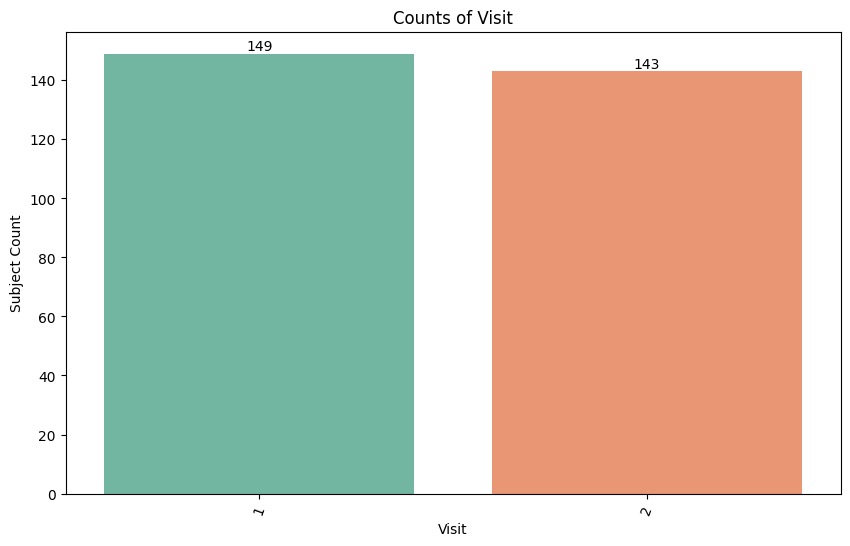

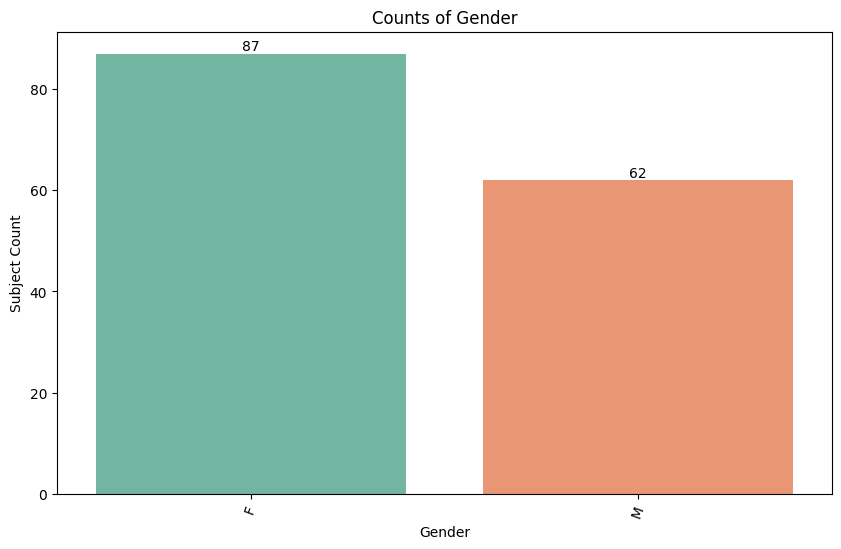

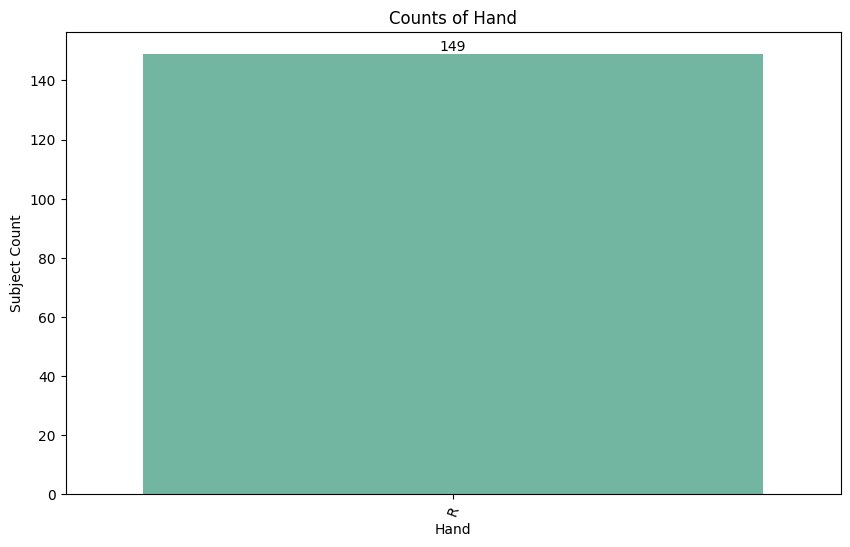

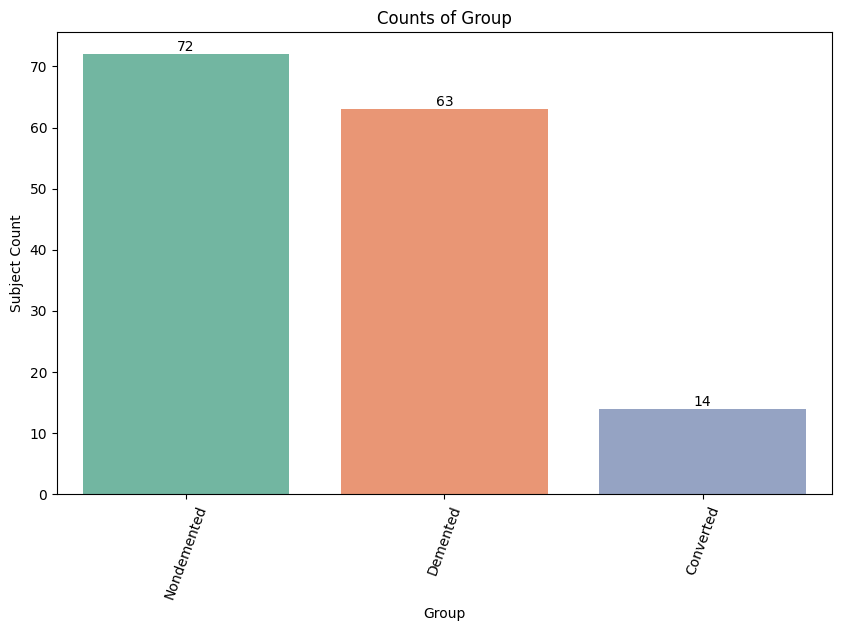

In [17]:
for column in ['Visit', 'Gender', 'Hand', 'Group']:
    # Count the unique occurrences of 'Subject ID' for each category in the column
    df_column = df.groupby(column)['Subject ID'].nunique().reset_index().rename(columns={'Subject ID': 'Unique Count'})

    # Sort by the count of unique 'Subject ID's
    df_column = df_column.sort_values(by='Unique Count', ascending=False).head(25)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    pal = sns.color_palette("pastel", len(df_column))
    bars = sns.barplot(x=column, y='Unique Count', data=df_column, palette="Set2", ax=ax)

    plt.xticks(rotation=70)
    plt.title(f'Counts of {column}')
    plt.xlabel(column)
    plt.ylabel('Subject Count')

    # Label each bar with the unique count
    for bar in ax.patches:
        ax.text(bar.get_x() + bar.get_width() / 2.,
                bar.get_height(),
                f'{int(bar.get_height())}',
                ha='center', va='bottom',
                color='black')

    # Display the plot
    plt.show()


There are six subjects who are missing MRI data for their second visit.

## Missing Visit 2 Data

In [18]:
df_sorted = df.sort_values(by=['Subject ID', 'Visit'])

# Identify subjects with both visits by checking the 'Visit' count for each 'Subject ID'
visit_counts = df_sorted['Subject ID'].value_counts()

# Get a list of subjects who have both visits
subjects_with_one_visits = visit_counts[visit_counts == 1]

In [19]:
subjects_with_one_visits = subjects_with_one_visits.index.tolist()

In [20]:
# Delete subjects with only one visits since they do not support longitudinal study
df = df[~df['Subject ID'].isin(subjects_with_one_visits)]

## Bar plot after cleaning

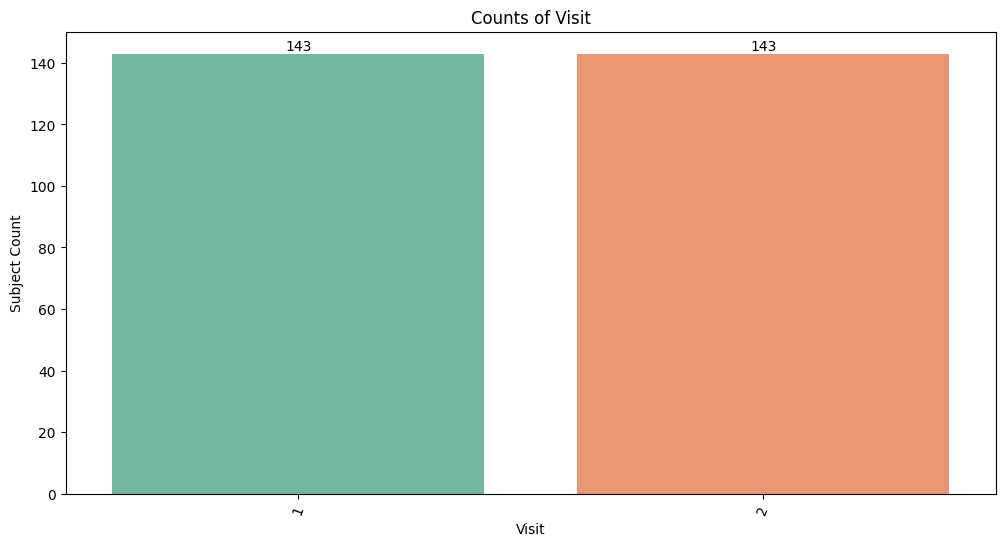

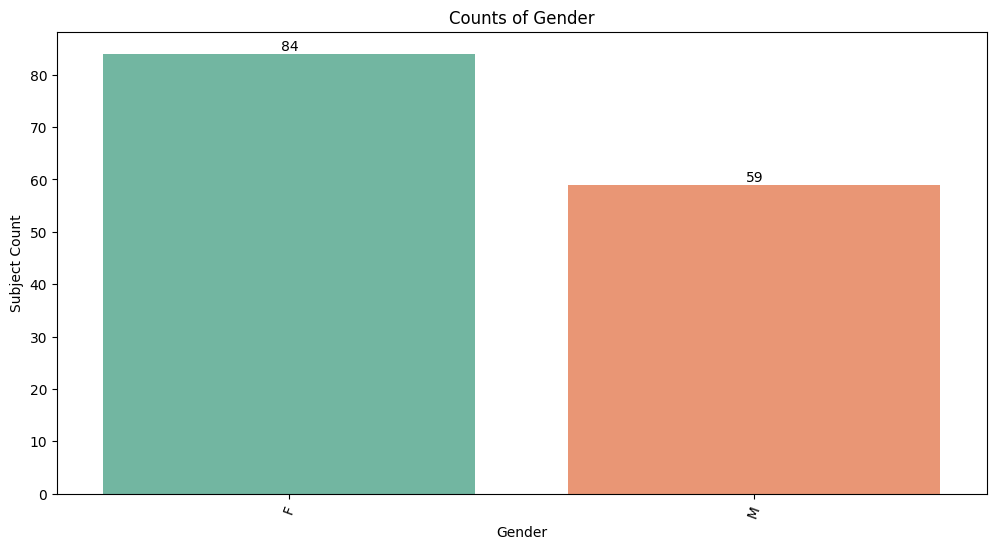

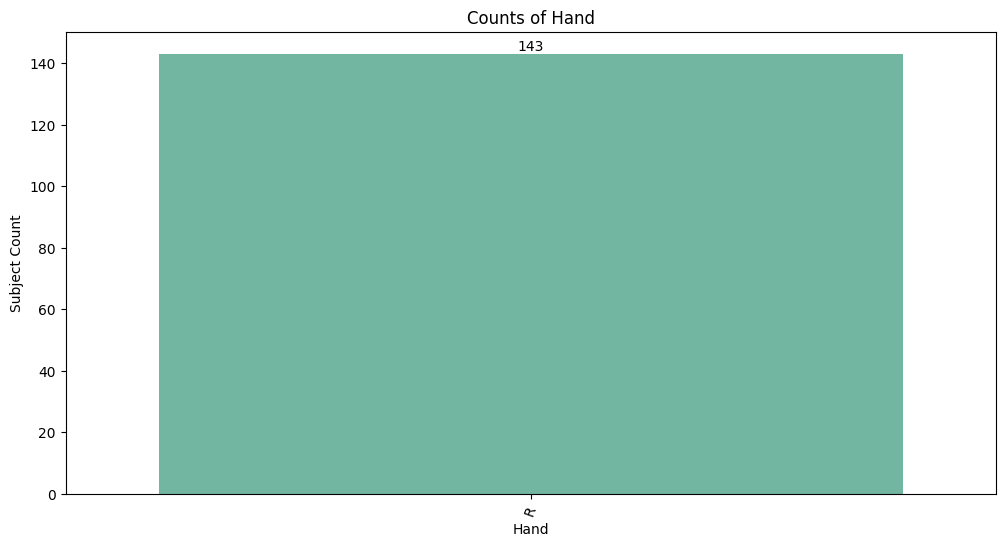

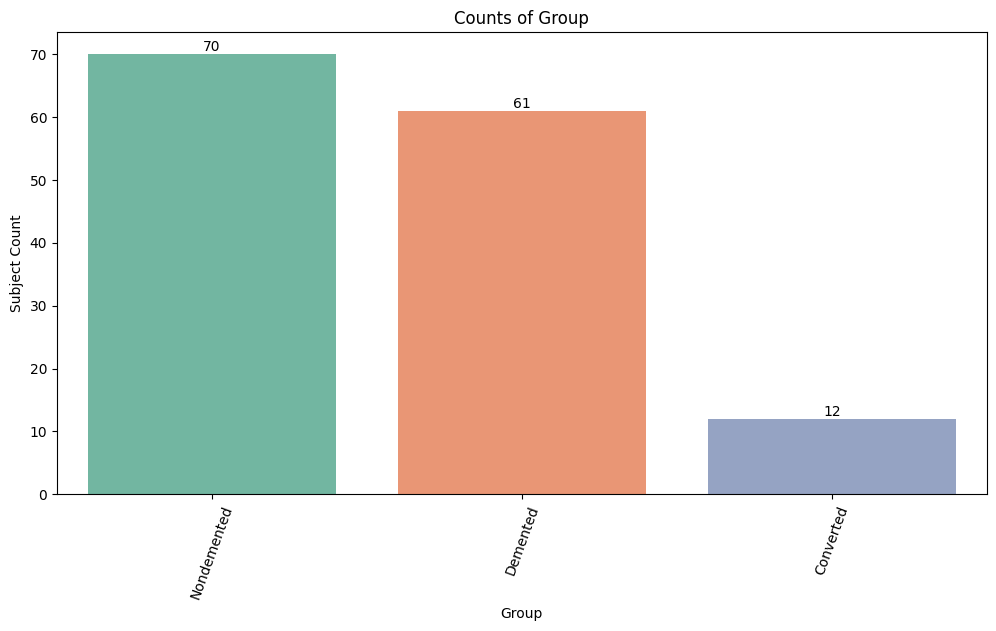

In [21]:
for column in ['Visit', 'Gender', 'Hand', 'Group']:
    # Count the unique occurrences of 'Subject ID' for each category in the column
    df_column = df.groupby(column)['Subject ID'].nunique().reset_index().rename(columns={'Subject ID': 'Unique Count'})

    # Sort by the count of unique 'Subject ID's
    df_column = df_column.sort_values(by='Unique Count', ascending=False).head(25)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    pal = sns.color_palette("pastel", len(df_column))
    bars = sns.barplot(x=column, y='Unique Count', data=df_column, palette="Set2", ax=ax)

    plt.xticks(rotation=70)
    plt.title(f'Counts of {column}')
    plt.xlabel(column)
    plt.ylabel('Subject Count')

    # Label each bar with the unique count
    for bar in ax.patches:
        ax.text(bar.get_x() + bar.get_width() / 2.,
                bar.get_height(),
                f'{int(bar.get_height())}',
                ha='center', va='bottom',
                color='black')

    # Display the plot
    plt.show()


## Distribution

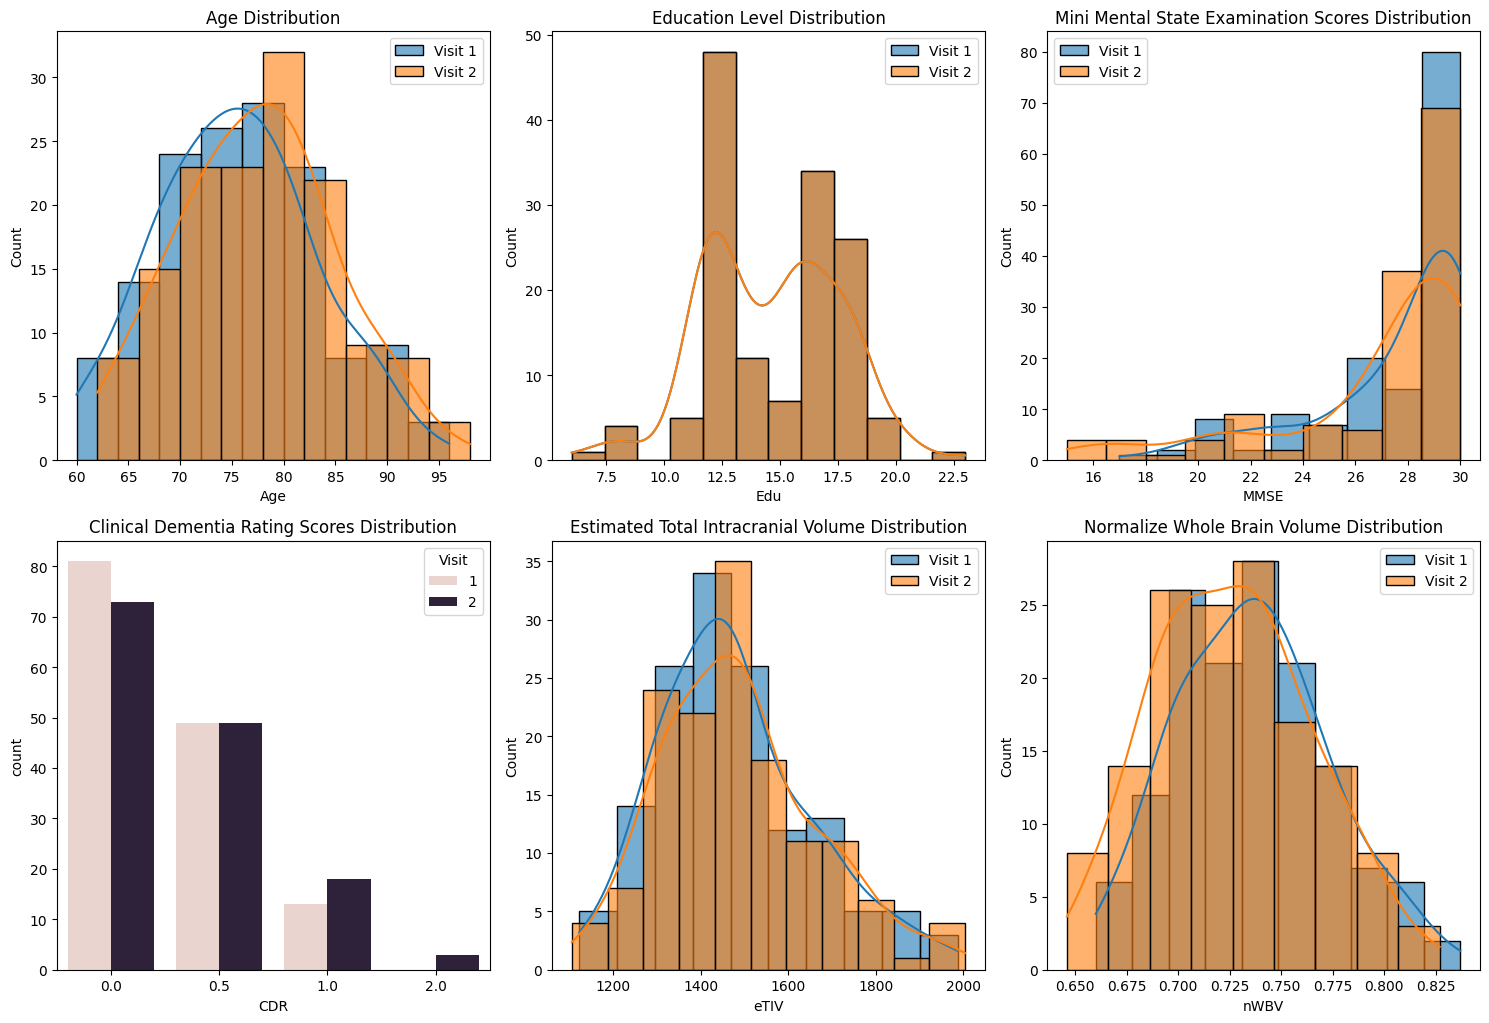

In [22]:
title_mapping = {
    'Age': 'Age Distribution',
    'Edu': 'Education Level Distribution',
    'MMSE': 'Mini Mental State Examination Scores Distribution',
    'CDR': 'Clinical Dementia Rating Scores Distribution',
    'eTIV': 'Estimated Total Intracranial Volume Distribution',
    'nWBV': 'Normalize Whole Brain Volume Distribution',
}

dist_columns = ['Age', 'Edu', 'MMSE', 'CDR', 'eTIV', 'nWBV']

fig = plt.figure(figsize=(15, 15))

# Loop through the selected columns for plotting
for i, column in enumerate(dist_columns):
    plt.subplot(3, 3, i+1)
    # Check if the column is categorical or 'CDR' which is treated as categorical in the original plot
    if df[column].dtype == 'O' or column == 'CDR':
        # Use hue to differentiate between visits
        sns.countplot(x=column, hue='Visit', data=df)
    else:
        # For continuous data, plot two histograms for visit 1 and visit 2
        sns.histplot(df[df['Visit'] == 1][column], kde=True, palette="pastel", label='Visit 1', alpha=0.6)
        sns.histplot(df[df['Visit'] == 2][column], kde=True, palette="pastel", label='Visit 2', alpha=0.6)
        plt.legend()
    plt.title(title_mapping.get(column, 'Distribution'))

plt.tight_layout()
plt.show()


## MMSE

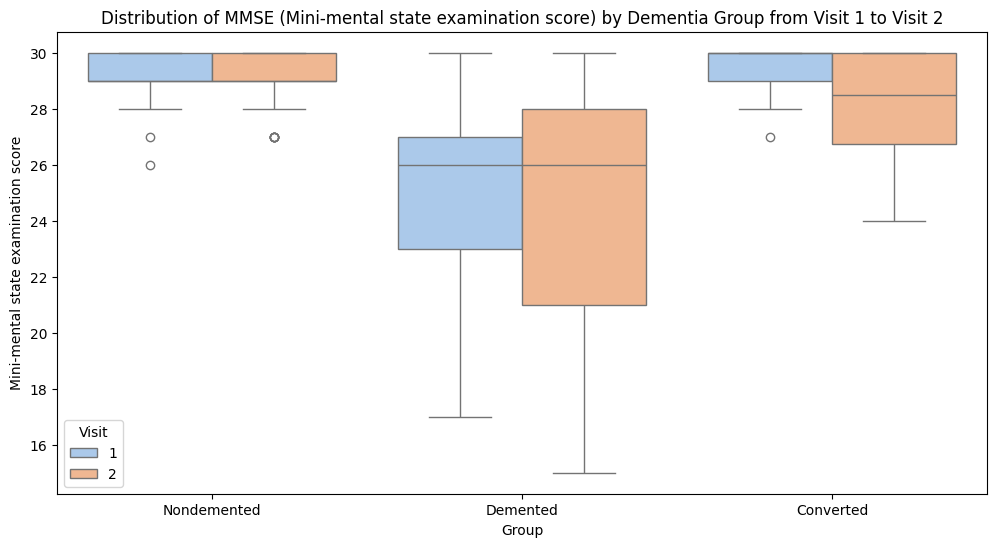

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Group", y="MMSE", hue="Visit", data=df, palette="pastel")
plt.xlabel("Group")
plt.ylabel("Mini-mental state examination score")

plt.title("Distribution of MMSE (Mini-mental state examination score) by Dementia Group from Visit 1 to Visit 2")
plt.show()

In [55]:
print('\nStatistics Summary of MMSE by Dementia Group\n')
df.groupby(['Group'])['MMSE'].agg(['mean','median','min','max','std','count']).round(2)


Statistics Summary of MMSE by Dementia Group



,mean,median,min,max,std,count
Group,,,,,,
Converted,28.67,29.0,24.0,30.0,1.74,24
Demented,24.73,26.0,15.0,30.0,3.92,122
Nondemented,29.15,29.0,26.0,30.0,0.91,140


## eTIV

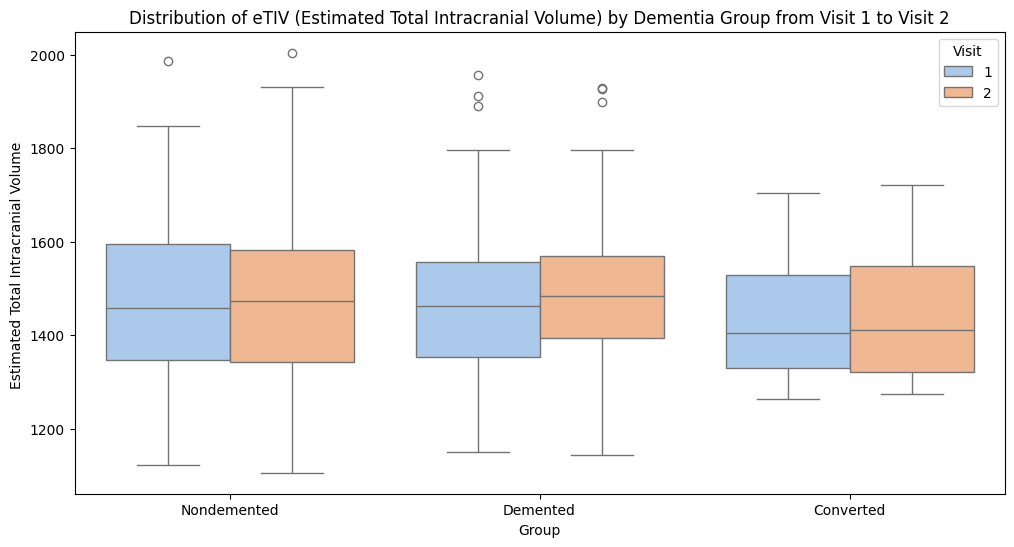

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Group", y="eTIV", hue="Visit", data=df, palette="pastel")
plt.xlabel("Group")
plt.ylabel("Estimated Total Intracranial Volume ")

plt.title("Distribution of eTIV (Estimated Total Intracranial Volume) by Dementia Group from Visit 1 to Visit 2")
plt.show()

## Clinical Dementia Rating

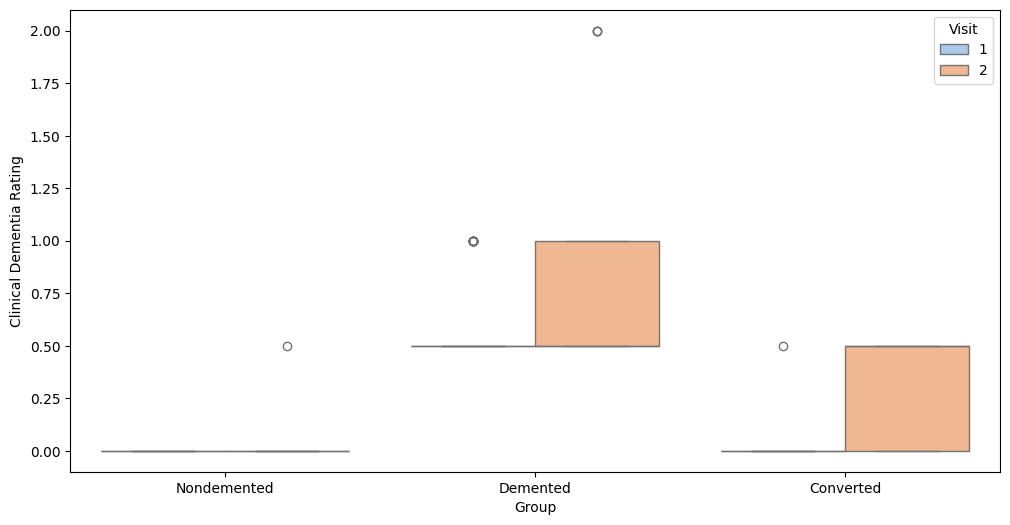

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Group", y="CDR", hue="Visit", data=df, palette="pastel")
plt.xlabel("Group")
plt.ylabel("Clinical Dementia Rating")
plt.show()

## nWBV

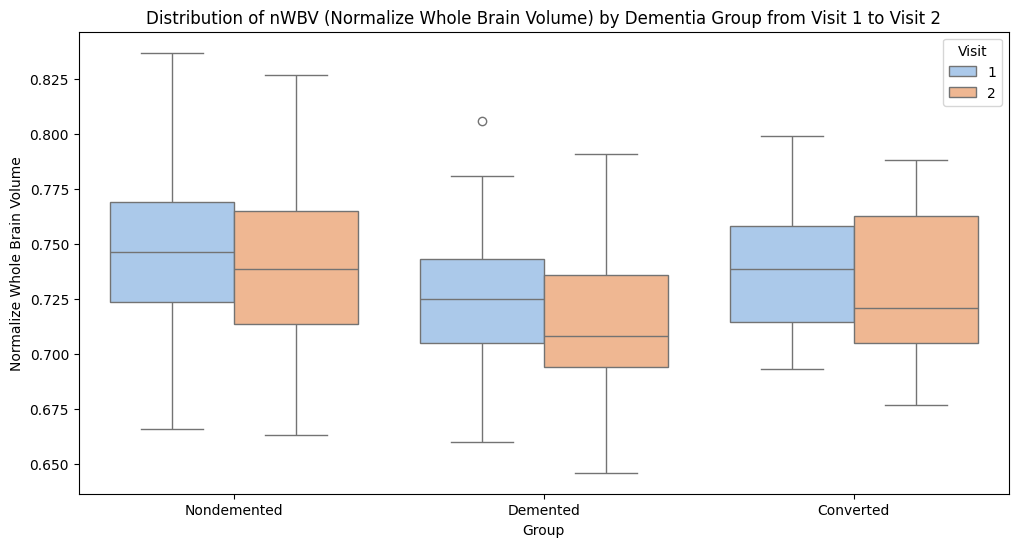

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Group", y="nWBV", hue="Visit", data=df, palette = "pastel")
plt.xlabel("Group")
plt.ylabel("Normalize Whole Brain Volume")

plt.title("Distribution of nWBV (Normalize Whole Brain Volume) by Dementia Group from Visit 1 to Visit 2")
plt.show()

# ANOVA - MMSE

In [27]:
!pip install pingouin
import pingouin as pg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 1.2 MB/s eta 0:00:00


In [28]:
res = pg.rm_anova(dv='MMSE', within='Visit', subject='Subject ID', data=df, detailed=True)
res.round(3)

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,Visit,22.378,1,22.378,8.574,0.004,0.007,1.0
1,Error,370.622,142,2.610,NaN,NaN,NaN,NaN


The results suggest that there is a statistically significant difference in the MMSE scores across the two visits with a p-value of 0.004, which is below the alpha level of 0.05 and therefore statistically significant. However, the effect size (ng2 = 0.007) is small, indicating that while the difference between visits is statistically significant, its practical or clinical significance might be limited.

In [29]:
res = pg.mixed_anova(dv='MMSE', within='Visit', between = 'Group', subject='Subject ID', data=df)
res.round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Group,1328.421,2,140,664.211,56.212,0.000,0.445,NaN
1,Visit,22.378,1,140,22.378,8.859,0.003,0.060,1.0
2,Interaction,17.000,2,140,8.500,3.365,0.037,0.046,NaN


SS = 17.000: Variance due to the interaction between 'Group' and 'Visit'.
DF1 = 2: This suggests that there are combinations of 'Group' and 'Visit' levels to be compared.
DF2 = 140: Degrees of freedom for the error term for the interaction.
MS = 8.500: Mean square for the interaction.
F = 3.365: The F-ratio for the interaction term, which is the ratio of variance explained by the interaction relative to the unexplained variance.
p-unc = 0.037: This p-value is less than 0.05, suggesting that the interaction effect is statistically significant.

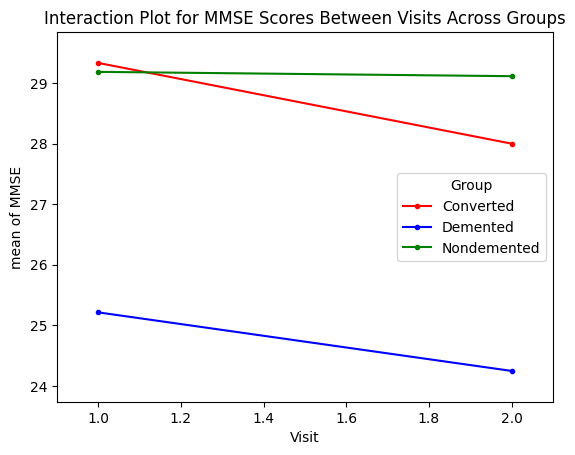

In [56]:
# Interaction plot for MMSE
interaction_plot = sm.graphics.interaction_plot(x=df['Visit'],
                                                trace=df['Group'],
                                                response=df['MMSE'],
                                                colors=['red', 'blue', 'green'])
plt.title("Interaction Plot for MMSE Scores Between Visits Across Groups")
plt.show()

## Post-hoc test

In [31]:
import statsmodels.stats.multicomp as multi

# You can use pairwise_tukeyhsd for multiple comparisons correction
post_hoc_results = multi.pairwise_tukeyhsd(df['MMSE'], df['Group'], alpha=0.05)

# Print summary of the results
print(post_hoc_results.summary())

# For within-group changes from Visit 1 to Visit 2, perform pairwise comparisons for each group.
# create subset of df by group and then perform post-hoc test
# For example:
for group in df['Group'].unique():
    group_data = df[df['Group'] == group]
    post_hoc_results = multi.pairwise_tukeyhsd(group_data['MMSE'], group_data['Visit'], alpha=0.05)
    print(f"Group: {group}")
    print(post_hoc_results.summary())


    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
Converted    Demented  -3.9372   0.0 -5.3522 -2.5221   True
Converted Nondemented   0.4833 0.695 -0.9167  1.8834  False
 Demented Nondemented   4.4205   0.0  3.6356  5.2054   True
-----------------------------------------------------------
Group: Nondemented
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0714 0.6422 -0.3748 0.2319  False
---------------------------------------------------
Group: Demented
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.9672 0.1746 -2.3694 0.4349  False
---------------------------------------------------
Group: Converted
Multiple

#Paired t-test for MMSE score for Converted Group

In [37]:
# Create pivot table
converted_df = df[df['Group'] == 'Converted']
converted_df['Visit'] = converted_df['Visit'].astype(int)
converted_mmse_scores = converted_df.pivot(index='Subject ID', columns='Visit', values='MMSE')

# Perform the paired t-test between MMSE scores for Visit 1 and Visit 2 within the 'Converted' group.
t_stat, p_value = stats.ttest_rel(converted_mmse_scores[1], converted_mmse_scores[2])

# Output the t-statistic and p-value
(t_stat, p_value)


(2.195886565426178, 0.050447189812943743)

In [42]:
len(converted_mmse_scores)

12

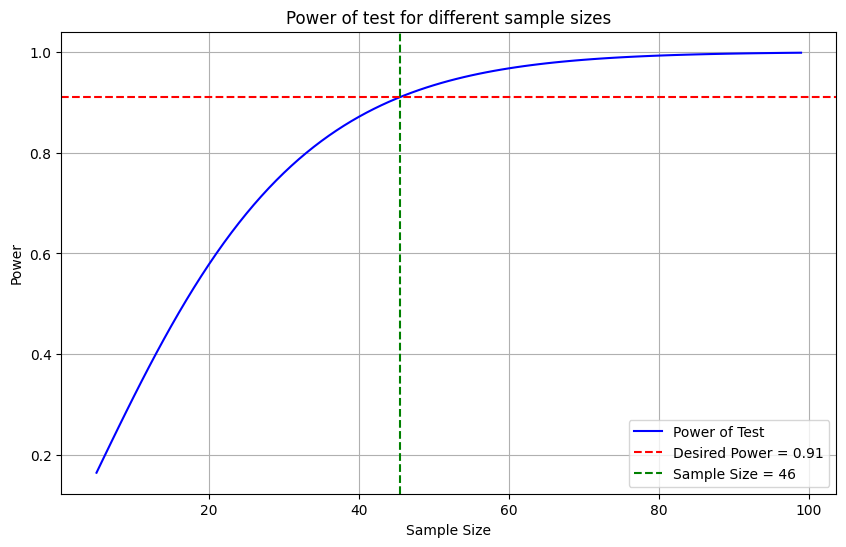

The appropriate sample size for a theoretical experiment with power = 0.91, alpha = 0.05, and  effect size = 0.7 would be 46.


In [51]:
from statsmodels.stats.power import TTestIndPower
import math

effect_size = 0.7
alpha = 0.05
power = 0.91

# Create an object of TTestIndPower
analysis = TTestIndPower()

# Calculate the sample size necessary for the given parameters
sample_size = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1, alternative='two-sided')

# Create a range of values for sample size
sample_sizes = np.array(range(5, 100))

# Calculate power values for the range of sample sizes
powers = analysis.power(effect_size=effect_size, nobs1=sample_sizes, alpha=alpha, ratio=1, alternative='two-sided')

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, powers, 'b-', label='Power of Test')
plt.axhline(y=power, color='red', linestyle='--', label=f'Desired Power = {power}')
plt.axvline(x=sample_size, color='green', linestyle='--', label=f'Sample Size = {math.ceil(sample_size)}')
plt.xlabel('Sample Size')
plt.ylabel('Power')
plt.title('Power of test for different sample sizes')
plt.legend()
plt.grid(True)
plt.show()

# Output the calculated sample size
print(f"The appropriate sample size for a theoretical experiment with power = 0.91, alpha = 0.05, and  effect size = 0.7 would be {math.ceil(sample_size)}.")


# Paired t-test for CDR for Converted Group

In [39]:
# Create pivot table
converted_cdr_scores = converted_df.pivot(index='Subject ID', columns='Visit', values='CDR')

# Perform the paired t-test between MMSE scores for Visit 1 and Visit 2 within the 'Converted' group.
t_stat, p_value = stats.ttest_rel(converted_cdr_scores[1], converted_cdr_scores[2])

# Output the t-statistic and p-value
(t_stat, p_value)

(-3.0225143871186098, 0.01160346666835706)

# ANOVA - eTIV

In [ ]:
res = pg.rm_anova(dv='eTIV', within='Visit', subject='Subject ID', data=df, detailed=True)
res.round(3)

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,Visit,5630.633,1,5630.633,9.282,0.003,0.001,1.0
1,Error,86141.867,142,606.633,NaN,NaN,NaN,NaN


In [ ]:
res = pg.mixed_anova(dv='eTIV', within='Visit', between = 'Group', subject='Subject ID', data=df)
res.round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Group,46820.769,2,140,23410.385,0.378,0.686,0.005,NaN
1,Visit,5630.633,1,140,5630.633,9.265,0.003,0.062,1.0
2,Interaction,1060.169,2,140,530.084,0.872,0.420,0.012,NaN


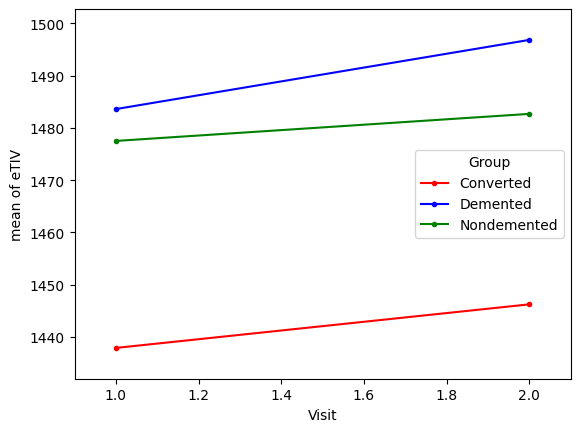

In [ ]:
# Interaction plot for eTIV
interaction_plot = sm.graphics.interaction_plot(x=df['Visit'],
                                                trace=df['Group'],
                                                response=df['eTIV'],
                                                colors=['red', 'blue', 'green'])
plt.show()

# ANOVA - nWBV

In [ ]:
res = pg.rm_anova(dv='nWBV', within='Visit', subject='Subject ID', data=df, detailed=True)
res.round(3)

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,Visit,0.007,1,0.007,96.455,0.0,0.016,1.0
1,Error,0.010,142,0.000,NaN,NaN,NaN,NaN


In [49]:
res = pg.mixed_anova(dv='nWBV', within='Visit', between = 'Group', subject='Subject ID', data=df)
res.round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Group,0.034,2,140,0.017,6.800,0.002,0.089,NaN
1,Visit,0.007,1,140,0.007,97.523,0.000,0.411,1.0
2,Interaction,0.000,2,140,0.000,1.786,0.171,0.025,NaN


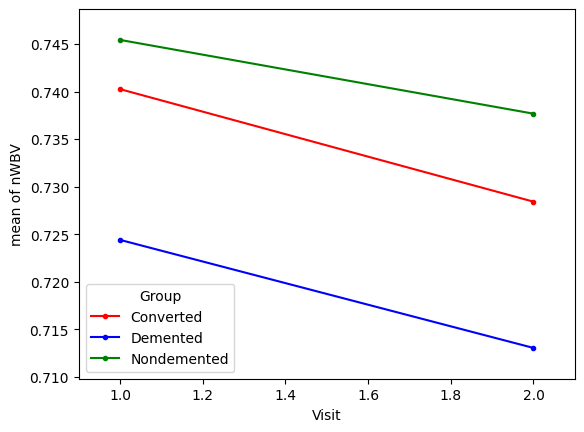

In [50]:
# Interaction plot for eTIV
interaction_plot = sm.graphics.interaction_plot(x=df['Visit'],
                                                trace=df['Group'],
                                                response=df['nWBV'],
                                                colors=['red', 'blue', 'green'])
plt.show()

# Observe "Change"

In [ ]:
print(df.groupby('Subject ID')["CDR"])

In [ ]:
change_columns = ['MR Delay', 'Age', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']

# Group by 'Subject ID' and then take the difference of the columns of interest
change_df = df.groupby('Subject ID')[change_columns].diff().dropna()

# Reset the index to clean up the DataFrame (if needed)
change_df.reset_index(drop=True, inplace=True)

# Optionally, rename columns to indicate that these are changes/differences
change_df.columns = ['Change in ' + col for col in change_df.columns]


# Show the DataFrame
change_df

,Change in MR Delay,Change in Age,Change in MMSE,Change in CDR,Change in eTIV,Change in nWBV,Change in ASF
0,457.0,1.0,3.0,0.0,17.0,-0.015,-0.007
1,560.0,1.0,5.0,0.0,60.0,-0.023,-0.036
2,538.0,2.0,-1.0,0.0,-15.0,0.008,0.018
3,1010.0,3.0,1.0,0.5,12.0,-0.001,-0.007
4,742.0,2.0,-1.0,0.0,-15.0,0.005,0.016
...,...,...,...,...,...,...,...
138,-776.0,-2.0,3.0,0.0,7.0,0.002,-0.005
139,-182.0,0.0,0.0,0.0,-11.0,0.006,0.009
140,553.0,1.0,-3.0,0.5,-3.0,-0.025,0.003
141,842.0,2.0,0.0,0.0,-11.0,-0.017,0.007


In [ ]:
# Select only the 'Subject ID' and 'Group' columns, then drop duplicates
subjects_group_df = df[['Subject ID', 'Group']].drop_duplicates()

subjects_group_df.reset_index(drop=True, inplace=True)

# Show the resulting DataFrame
subjects_group_df

,Subject ID,Group
0,OAS2_0001,Nondemented
1,OAS2_0002,Demented
2,OAS2_0004,Nondemented
3,OAS2_0005,Nondemented
4,OAS2_0008,Nondemented
...,...,...
138,OAS2_0182,Demented
139,OAS2_0183,Nondemented
140,OAS2_0184,Demented
141,OAS2_0185,Demented


In [ ]:
change_df = subjects_group_df.join (change_df, how='left')

In [ ]:
change_df

,Subject ID,Group,Change in MR Delay,Change in Age,Change in MMSE,Change in CDR,Change in eTIV,Change in nWBV,Change in ASF
0,OAS2_0001,Nondemented,457.0,1.0,3.0,0.0,17.0,-0.015,-0.007
1,OAS2_0002,Demented,560.0,1.0,5.0,0.0,60.0,-0.023,-0.036
2,OAS2_0004,Nondemented,538.0,2.0,-1.0,0.0,-15.0,0.008,0.018
3,OAS2_0005,Nondemented,1010.0,3.0,1.0,0.5,12.0,-0.001,-0.007
4,OAS2_0008,Nondemented,742.0,2.0,-1.0,0.0,-15.0,0.005,0.016
...,...,...,...,...,...,...,...,...,...
138,OAS2_0182,Demented,-776.0,-2.0,3.0,0.0,7.0,0.002,-0.005
139,OAS2_0183,Nondemented,-182.0,0.0,0.0,0.0,-11.0,0.006,0.009
140,OAS2_0184,Demented,553.0,1.0,-3.0,0.5,-3.0,-0.025,0.003
141,OAS2_0185,Demented,842.0,2.0,0.0,0.0,-11.0,-0.017,0.007
